## Introduction
A regime analysis is significant in asset allocation and asset-liability management for
long-term investors because of the contagion and related effects during crash periods: the
correlation between risky assets and volatility will greatly increase during the crash
periods, thus creating severe difficulty in risk management and protecting investor capital
with traditional portfolio models.

Many existing methods are based on econometric models which assume a fixed structural model. However,
financial return or macroeconomic data tends to be noisy and affected by myriad of
factors. The state-of-the-art approach discussed in Mulvey and Liu (2016), trend-filtering,
is non-parametric, data-driven and model-free. The algorithm was first introduced by
Kim et al. (2009) and generalised in Tibshirani (2014).

In this part, we will implement the algorithm to obtain regimes of U.S. equity. First, we need the relevant packages and data.

In [1]:
import numpy as np #for numerical array data
import pandas as pd #for tabular data
from scipy.optimize import minimize
from scipy.optimize import linprog
import matplotlib.pyplot as plt #for plotting purposes
import matplotlib
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import cvxpy as cp

In [2]:
# Import Data
SP500_data = pd.read_csv('datasets/SP500.csv')
SP500_data.head()

,DATE,SP500,SP500TR
0,1/1/85,0.5585,84.7932
1,2/1/85,7.4747,91.1312
2,3/1/85,5.5791,96.2155
3,4/1/85,-1.1260,95.1321
4,5/1/85,5.3201,100.1932


In the trend-filtering algorithm, we manage to find some ‘fitted’ time series that serves as the signal of the trend. This new time series can be obtained by solving the following optimizationproblem:

\begin{equation*} 
    \hat{\beta} = \text{argmin}_{\beta \in \mathbb{R}^n} ||x-\beta||_2^2 + \lambda||D\beta||_1 .
\end{equation*}

where

\begin{equation*} 
D =
    \begin{bmatrix}
       1 & -1 & 0 & \dots & 0 & 0  \\
       0  & 1 &-1 & \dots & 0 & 0 \\
       \vdots \\
       0  & 0 & 0 & \dots & -1 & 0\\
       0  & 0 & 0 & \dots & 1 & -1
    \end{bmatrix}
\in \mathbb{R}^{(n-1)\times n}.
\end{equation*}

In [3]:
ret = SP500_data.as_matrix(columns=['SP500']) # Percentage
n = np.size(ret)
x_ret = ret.reshape(n)

Dfull = np.diag([1]*n) - np.diag([1]*(n-1),1)
D = Dfull[0:(n-1),]

/anaconda3/envs/TrendFiltering/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [4]:
# Scipy Implementation - satisfactory
'''
lamb = 16
def trend_filtering(x):
    return np.sum((x_ret-x)**2) + lamb * np.sum(np.abs(x[1:]-x[:-1]))

res = minimize(trend_filtering, ret/2, method="SLSQP",tol=1e-6,options={'maxiter':10000})
res.fun
'''

'\nlamb = 16\ndef trend_filtering(x):\n    return np.sum((x_ret-x)**2) + lamb * np.sum(np.abs(x[1:]-x[:-1]))\n\nres = minimize(trend_filtering, ret/2, method="SLSQP",tol=1e-6,options={\'maxiter\':10000})\nres.fun\n'

In [5]:
# CVXPY Implementation
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
x_ret = ret.reshape(n)

def tf_obj(x,beta,lambd):
    return cp.norm(x-beta,2)**2 + lambd*cp.norm(cp.matmul(D, beta),1)

problem = cp.Problem(cp.Minimize(tf_obj(x_ret, beta, lambd)))

lambd.value = 16
problem.solve()

#beta.value

6318.804147421546

## Regime Identification

Once we obtain the "smoothed" betas, we will label the month "normal" for positive betas and "crash" for negative betas.

In [6]:
# [[To do]] Plot the log SP500 along with the regime
SP500 = SP500_data.as_matrix(columns=['SP500TR'])

/anaconda3/envs/TrendFiltering/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [7]:
#Convert beta of a pd.Series object so I can use parseBetaSeries function
betas = pd.Series(beta.value)

In [8]:
def parseBetaSeries(betaValues):
    '''parseNonZero takes a array of non-zero indecies, and max array index,
    returns the proportions to be use in the array filtering
    Inputs:
        betaValues: pd.Series object
    Outputs:
        l: list object, that looks like [start_0, end_0, start_1, end_1...]'''
    
    #Step 1: create an array -2 and 0s where -2 corresponds to a negative beta value
    betas = betaValues.apply(np.sign)
    betas = betas - 1
    nonZeroArray = betas.nonzero()
    nonZeroArray = nonZeroArray[0]
    
    #Step 1.1: get the length of the original array
    n = len(betas)
    
    #Step 2: compute the start and end point of the negative regimes
    l = list()
    
    if (len(nonZeroArray) == 0): #Check if there are no regimes return a empty list
        return l
    else: #if there are regimes, process them
        start = nonZeroArray[0]
        previous = start
        for i in range(1,len(nonZeroArray)):
            if(previous + 1 != nonZeroArray[i]): #i.e you have hit the end of a range
                l.append(1.0*start/n)
                l.append(1.0*previous/n)
                start = nonZeroArray[i]
                previous = nonZeroArray[i]
            else: #you haven't hit the end of a range
                previous = nonZeroArray[i]
        #add the last range
        l.append(1.0*start/n)
        l.append(1.0*previous/n)
        return l
            

In [9]:
def plotRegime(dataSeries, betaSeries, ymaxvar=8000, regimeColor='grey', alpha=.05,
              title='Series over time'):
    '''plotRegime takes the above arguments, makes the regime dependent plot
    Inputs:
        dataSeries: y values, should be either a pd.DataFrame column, or a 1xn matrix
        betaSeries: pd.Series object, should be length n
        ymaxvar: optional plotting argument, sets max of y label
        regimeColor: optional plotting arument, regime color
        alpha: optional plotting argument, sets transparency of regimeColor
        title: optional plotting argument, sets title of plot
    Outputs:
        should plot stuff'''
    #Step 1: Return list of negative bear market indecies
    listOfRegimes = parseBetaSeries(betaSeries)
    #Step 2: Create the plot
    fig, ax = plt.subplots()
    for i in range(int(len(listOfRegimes)/2)):
        ax.axhspan(0, ymaxvar, xmin=listOfRegimes[2*i], xmax=listOfRegimes[2*i+1], facecolor='grey', alpha=0.5)
        
    plt.semilogy(SP500, color='black')
    plt.ylim(1,ymaxvar)
    plt.title(title)
    #Step 3: Show the plot
    plt.show()

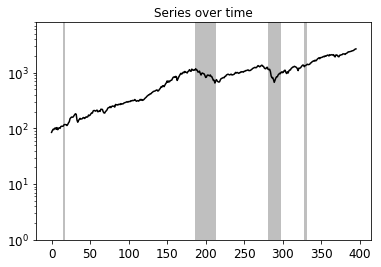

In [10]:
plotRegime(SP500, betas, title='Series over time')

### Some changes need to be applied to the plot:
1) Time period: 1985-2017 (see dataset)

2) Since the span of SP500 is large, use log series of SP500 in the plot (black line)

&nbsp; [<img src="regime_sample.jpg">]

## Part : Notice that the number of regimes is a function of lambda

### Smaller lambda values lead to more regimes

In [37]:
# Run code with whichever lambbda value you would like!
lambd.value = 10 # Also try 14, 13, 12, 11 and 10

In [38]:
problem.solve()
betas = pd.Series(beta.value)

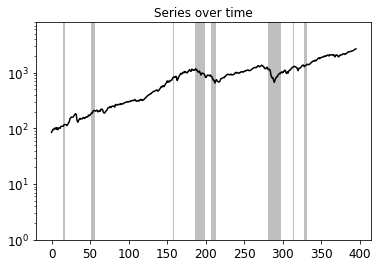

In [39]:
plotRegime(SP500, betas, title='Series over time')

# Part : We can plot the number of regimes as a function of lambda

In [32]:
lambd_values = np.logspace(0, 2, 100)

beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()

    beta_values.append(beta.value)


In [34]:
#Plot the number of regimes as a funciton of lambda
nregimes = np.zeros((len(lambd_values),1))
for i in range(len(lambd_values)):
    l = parseBetaSeries(pd.Series(beta_values[i]))
    nregimes[i] = len(l)/2

Text(0, 0.5, 'Number of Regimes')

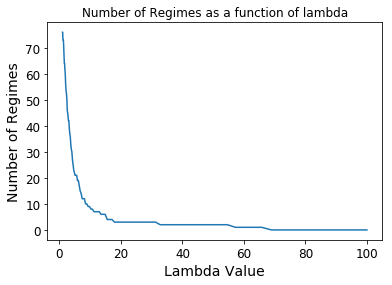

In [41]:
#Plot the number of regimes verses lambda
plt.plot(lambd_values, pd.DataFrame(nregimes))
plt.title('Number of Regimes as a function of lambda')
plt.xlabel('Lambda Value')
plt.ylabel('Number of Regimes')